In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv")

In [3]:
import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

2024-05-20 14:53:50.333920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 14:53:50.333999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 14:53:50.335755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_df = train_df.drop("id", axis = 1)

In [5]:
df_train = train_df.sample(frac=0.7, random_state=0)
df_valid = train_df.drop(df_train.index)

X_train = df_train.drop('FloodProbability', axis=1)
y_train = df_train['FloodProbability']
X_valid = df_valid.drop('FloodProbability', axis=1)
y_valid = df_valid['FloodProbability']

y_mean = np.mean(y_train)
y_std = np.std(y_train)
y_train_normalized = (y_train - y_mean) / y_std

y_mean = np.mean(y_valid)
y_std = np.std(y_valid)
y_valid_normalized = (y_valid - y_mean) / y_std

input_shape = [X_train.shape[1]]

In [6]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(units = 512, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units = 512, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units = 512, activation = "relu"),
    layers.Dense(units = 1)
])

model.compile(
    loss = "mse",
    optimizer = "adam",
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
history = model.fit(
    X_train, y_train_normalized,
    batch_size=1024,
    validation_data = (X_valid, y_valid_normalized),
    epochs=1000,
    callbacks=[early_stopping]
)

Epoch 1/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - loss: 0.3948 - val_loss: 0.1589
Epoch 2/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - loss: 0.1713 - val_loss: 0.1475
Epoch 3/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - loss: 0.1563 - val_loss: 0.1426
Epoch 4/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 0.1512 - val_loss: 0.1461
Epoch 5/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 0.1492 - val_loss: 0.1411
Epoch 6/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 80s 53ms/step - loss: 0.1474 - val_loss: 0.1402
Epoch 7/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.1465 - val_loss: 0.1394
Epoch 8/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.1455 - val_loss: 0.1389
Epoch 9/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.1453 - val_loss: 0.1397
Epoch 10/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 0.1445 - val_loss: 0.1393
Epoch 11/1000
765/765 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.1445 - val_loss: 0.1403
Epoch 12

Minimum validation loss: 0.13603216409683228


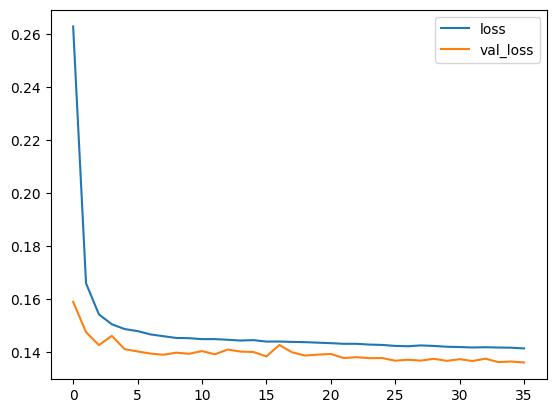

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [9]:
from sklearn.metrics import r2_score

predictions = model.predict(X_valid)

y_mean = np.mean(y_train)
y_std = np.std(y_train)
predictions_original_scale = predictions * y_std + y_mean

r2 = r2_score(y_valid, predictions_original_scale)

10481/10481 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step


In [10]:
r2

0.8633115462065527

In [11]:
test_df = test_df.drop("id", axis = 1)
test_predictions = model.predict(test_df)
test_predictions_scale = test_predictions * y_std + y_mean

23291/23291 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step


# EDA

In [12]:
import pandas as pd
eda = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv")

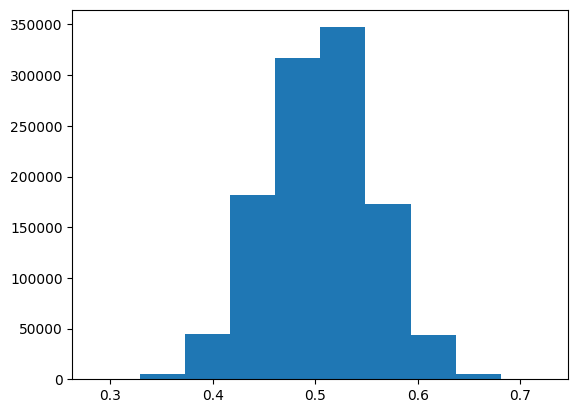

In [13]:
import matplotlib.pyplot as plt
plt.hist(eda['FloodProbability'])
plt.show()

Very Normal Distribution shaped.

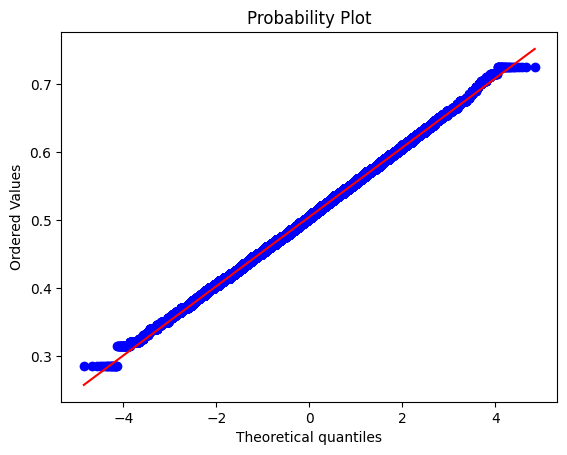

In [14]:
import pylab as py 
import scipy.stats as stats

stats.probplot(eda['FloodProbability'], dist="norm", plot=py)
py.show()

In [15]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv")
test_data = test_df.copy().drop("id", axis = 1)
test_predictions = model.predict(test_data)
test_predictions_scale = test_predictions * y_std + y_mean

23291/23291 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step


In [16]:
test_df['FloodProbability'] = test_predictions_scale
final_df = test_df[['id', 'FloodProbability']]
final_df.to_csv('submission.csv', index = False, header = True)